<a href="https://colab.research.google.com/github/anshupandey/Time-Series-Forecasting/blob/main/Time_Series_Forecasting_with_LSTM_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting with LSTM

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [20]:


# Step 1: Data Preparation
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Load dataset
data = pd.read_csv('InternationRoaming_singapore.csv')
data.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access
/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [22]:



data['ds'] = pd.to_datetime(data['ds'])
values = data['y'].values.reshape(-1, 1)  # Percentage of visitors

# Normalize data
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Create sequences
sequence_length = 12  # Using past 12 months for prediction
X, y = create_sequences(values, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



In [24]:
# Step 2: Model Design
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Only the last output
        return output


In [25]:
# Hyperparameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
epochs = 50

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
!pip install torchviz --quiet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Step 3: Training
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/50], Loss: 0.0473
Epoch [20/50], Loss: 0.0403
Epoch [30/50], Loss: 0.0238
Epoch [40/50], Loss: 0.0099
Epoch [50/50], Loss: 0.0071


In [28]:
# Step 4: Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    predictions = scaler.inverse_transform(predictions.numpy())
    actuals = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


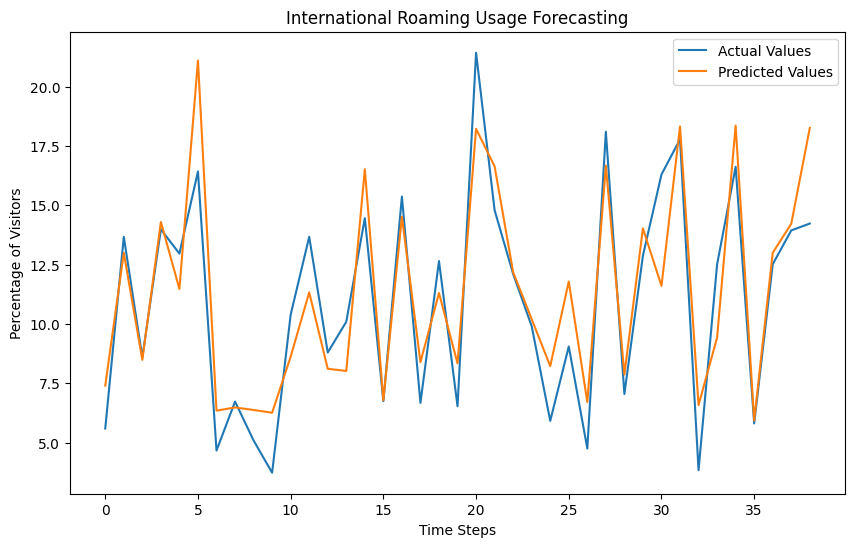

In [29]:
# Step 5: Visualization
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Percentage of Visitors')
plt.title('International Roaming Usage Forecasting')
plt.show()

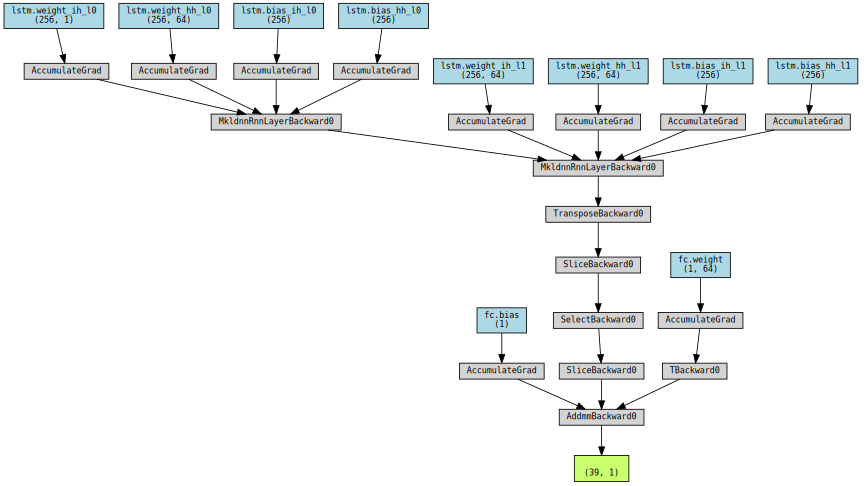

In [31]:
from torchviz import make_dot

predictions = model(X_test)
dot = make_dot(predictions, params=dict(model.named_parameters()))

# Save or display the visualization
dot.render("model_architecture", format="png") # Saves as model_architecture.png
dot